# MAD Competition

Maximum differentiation (MAD) competition comes from a paper published in 2008 by Zhou Wang and Eero Simoncelli ([reprint](https://www.cns.nyu.edu/pub/lcv/wang08-preprint.pdf) from LCV website). In MAD Competition, the goal is to efficiently compare two competing perceptual metrics. Like the inputs for all synthesis methods in `plenoptic`, metrics operate on images and produce predictions related to perception. As originally conceived, the metrics in MAD competition are either similarity (e.g., SSIM) or distance (e.g., MSE) metrics: they take two images and return a scalar value that gives a perceptual similarity or distance. For distance metrics, the smaller this number is, the more perceptually similar the metric predicts they will be; for similarity metrics, the larger the number is, the more percpetually similar.

In `plenoptic`, a single instantiation of `MADCompetition` synthesizes a single image, holding the `fixed_metric` constant while either maximizing or minimizing `synthesis_metric`, depending on the value of `synthesis_target`. A full set of MAD competition images consists of four images, maximizing and minimizing each of the two metrics. For each pair of images, one metric predicts they are perceptually identical, while the other metric predicts they are as dissimilar as possible. This set therefore allows us to efficiently compare the two models.

In the paper, these images are generated by manually computing the gradients, projecting one gradient out of the other, and repeating until convergence was reached. This doesn't work as well in the general case, so we instead optimize using the following objective function:

$$t L_1(x, \hat{x}) + \lambda_1 [L_2(x, x+\epsilon) - L_2(x, \hat{x})]^2 + \lambda_2 \mathcal{B}(\hat{x})$$

where $t$ is 1 if `mad.synthesis_target` is `'min'` and -1 if it's `'max'`, $L_1$ is `mad.synthesis_metric`, $L_2$ is `mad.fixed_metric`, $x$ is `mad.reference_signal`, $\hat{x}$ is `mad.synthesized_signal`, $\epsilon$ is the initial noise, $\mathcal{B}$ is the quadratic bound penalty, $\lambda_1$ is `mad.metric_tradeoff_lambda` and $\lambda_2$ is `mad.range_penalty_lambda`.


That's the general idea, now let's explore how to use the `MADCompetition` class for generating these images

In [1]:
import plenoptic as po
import imageio
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np
import warnings

%load_ext autoreload
%autoreload 2

## Basic usage

As with all our synthesis methods, we start by grabbing a target image and initalizing our models.

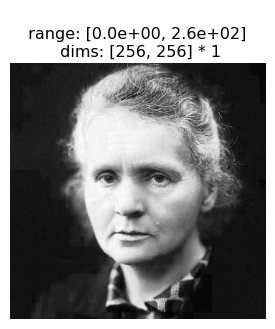

In [2]:
img = po.tools.data.load_images(['../data/256/curie.pgm'])
img = 255*img
po.imshow(img);

To start, we'll demonstrate MAD competition as described in the paper, using two metrics: SSIM (structural similarity index, described [here](https://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf)) and MSE (mean-squared error), implementations for both of which are found in `plenoptic.metric`. We use the weighted version of SSIM described in the MAD Competition paper, and images that range between 0 and 255, hence the keyword arguments passed to `ssim` below.

In [3]:
model1 = lambda *args: po.metric.ssim(*args, weighted=True, dynamic_range=255)
model2 = po.metric.mse

To intitialize the method, we only need to specify the target image (as a 4d tensor, as returned by `load_images`), the two metrics, and the target. To start, we will hold MSE constant, while minimizing SSIM.

In [4]:
mad = po.synth.MADCompetition(img, synthesis_metric=model1, fixed_metric=model2, synthesis_target='min', allowed_range=(0, 255), initial_noise=10)

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/mad_competition.py:126: UserWarning: Since metric_tradeoff_lamda was None, automatically set to 0.009999999776482582 to roughly balance metrics.
  warnings.warn("Since metric_tradeoff_lamda was None, automatically set"


At the most basic, all we need to do is call `mad.synthesize()`. Let's do that and then view the outcome (we set `store_progress=True` so that we store the synthesis progress as well as the final outcome). There are several additional arguments to `synthesize()` but none are required.

  0%|          | 0/200 [00:00<?, ?it/s]

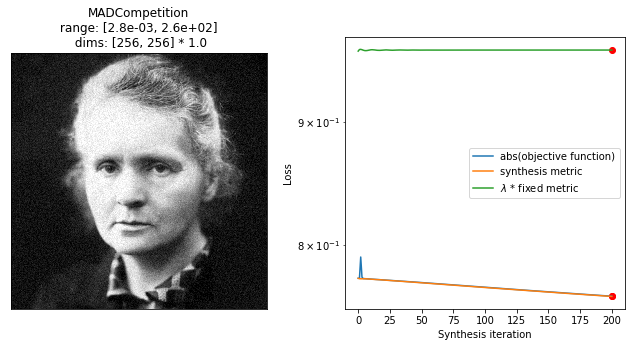

In [5]:
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    mad.synthesize(store_progress=True, max_iter=200)
fig = po.synth.mad_competition.plot_synthesis_status(mad)

We can see from the loss plot that SSIM's loss is decreasing, while MSE's is staying roughly constant. However, SSIM's loss hasn't decreased that much, so let's continue running synthesis!

To continue synthesis, we can simply call `mad.synthesize()` again. `store_progress` will need to have the same argument (and `optimizer` and `scheduler` will both need to be None), but we then pick up right where we left off.

  0%|          | 0/1000 [00:00<?, ?it/s]

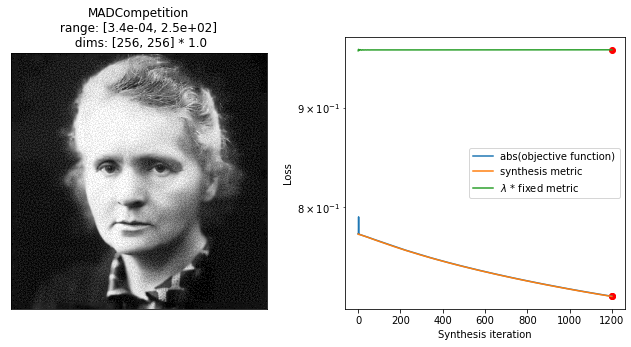

In [6]:
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    mad.synthesize(store_progress=True, max_iter=3000)
fig = po.synth.mad_competition.plot_synthesis_status(mad)

We could continue this, but we see that we're starting to level off.

As described in the opening paragraph, a full set of MAD competition synthesized images consists of four images. In order to create the other images, we must create a new instance of `MADCompetition`. Let's do that for the other images now:

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/mad_competition.py:126: UserWarning: Since metric_tradeoff_lamda was None, automatically set to 0.009999999776482582 to roughly balance metrics.
  warnings.warn("Since metric_tradeoff_lamda was None, automatically set"


  0%|          | 0/3000 [00:00<?, ?it/s]

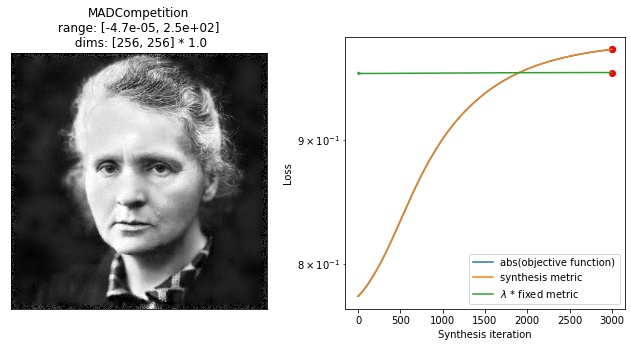

In [7]:
mad_ssim_max = po.synth.MADCompetition(img, synthesis_metric=model1, fixed_metric=model2, synthesis_target='max', allowed_range=(0, 255), initial_noise=10)

with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    mad_ssim_max.synthesize(store_progress=True, max_iter=3000)
fig = po.synth.mad_competition.plot_synthesis_status(mad_ssim_max)

Holding SSIM constant while changing MSE is a bit trickier. Note that we set a very large `metric_tradeoff_lambda` value in order to increase the weight of SSIM's divergence from the target value in the objective function.

  0%|          | 0/1000 [00:00<?, ?it/s]

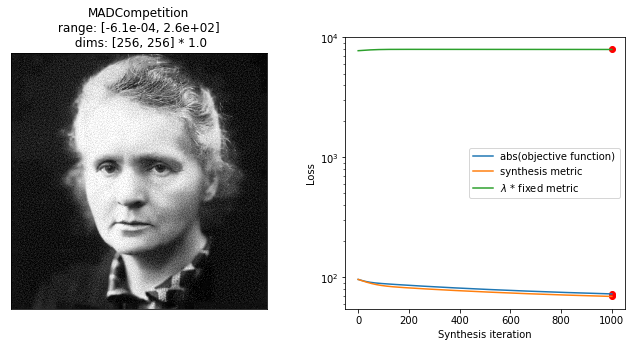

In [8]:
mad_mse_min = po.synth.MADCompetition(img, synthesis_metric=model2, fixed_metric=model1, synthesis_target='min', allowed_range=(0, 255), initial_noise=10, metric_tradeoff_lambda=1e4)

with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    mad_mse_min.synthesize(store_progress=True, max_iter=1000)
fig = po.synth.mad_competition.plot_synthesis_status(mad_mse_min)

Maximizing MSE is even trickier: unlike SSIM, MSE is unbounded and so can increase to a much larger value. The clever way to handle this would be an adaptive `metric_tradeoff_lambda`, which increases when necessary, but for now we solve this by just stopping synthesis quickly

  0%|          | 0/1500 [00:00<?, ?it/s]

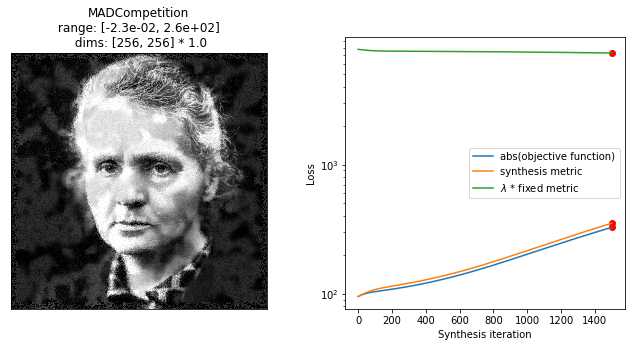

In [9]:
mad_mse_max = po.synth.MADCompetition(img, synthesis_metric=model2, fixed_metric=model1, synthesis_target='max', allowed_range=(0, 255), initial_noise=10, metric_tradeoff_lambda=1e4)

with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    mad_mse_max.synthesize(store_progress=True, max_iter=1500)
fig = po.synth.mad_competition.plot_synthesis_status(mad_mse_max)

We can then view all of these together:

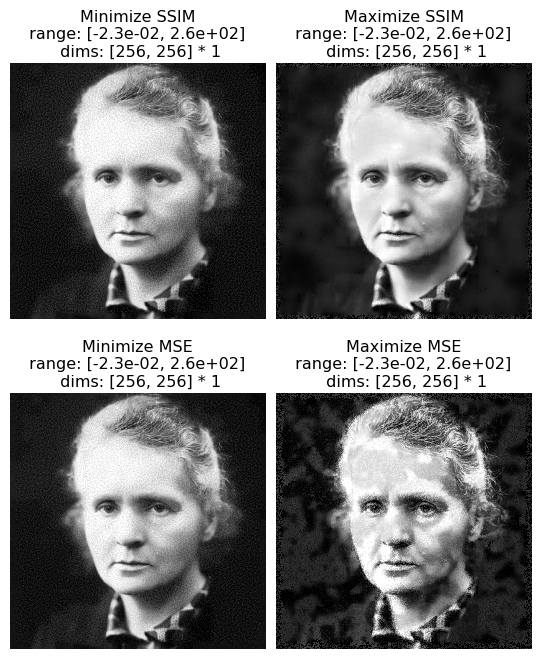

In [10]:
po.imshow([mad.synthesized_signal, mad_ssim_max.synthesized_signal, mad_mse_min.synthesized_signal, mad_mse_max.synthesized_signal],
          vrange='auto1', title=['Minimize SSIM', 'Maximize SSIM', 'Minimize MSE', 'Maximize MSE'], col_wrap=2);

From the following plot, we can see that we manage to hold MSE constant when targeting SSIM, but not the other way around. Need to work on this...

[Text(0.5, 1.0, 'MSE'), Text(0.5, 0, 'Iteration'), Text(0, 0.5, 'Loss')]

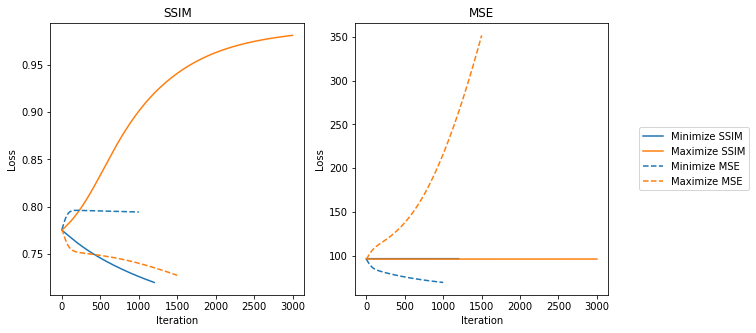

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].plot(mad.synthesis_metric_loss, 'C0', label='Minimize SSIM')
axes[0].plot(mad_ssim_max.synthesis_metric_loss, 'C1', label='Maximize SSIM')
axes[0].plot(mad_mse_min.fixed_metric_loss, 'C0--', label='Minimize MSE')
axes[0].plot(mad_mse_max.fixed_metric_loss, 'C1--', label='Maximize MSE')
axes[0].set(title='SSIM', xlabel='Iteration', ylabel='Loss')
axes[1].plot(mad.fixed_metric_loss, 'C0', label='Minimize SSIM')
axes[1].plot(mad_ssim_max.fixed_metric_loss, 'C1', label='Maximize SSIM')
axes[1].plot(mad_mse_min.synthesis_metric_loss, 'C0--', label='Minimize MSE')
axes[1].plot(mad_mse_max.synthesis_metric_loss, 'C1--', label='Maximize MSE')
axes[1].legend(loc='center left', bbox_to_anchor=(1.1, .5))
axes[1].set(title='MSE', xlabel='Iteration', ylabel='Loss')